# Enhance Depth Ground Truth with Trained Model

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julien/anaconda3/

## Metrics that are needed to load the model

In [2]:
def Masked_Mean_Absolute_Error(y_true, y_pred):
    '''Masked mean absolut error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    loss = K.mean(
                K.sum(
                        K.abs(y_true - y_pred) * A_i,
                        axis=(1,2,3)
                     )
                /
                K.sum(A_i, axis=(1,2,3))
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss


def Masked_Mean_Absolute_Error_Sigmoid(y_true, y_pred):
    '''Masked mean absolut error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # Since we are using a sigmoid activation function, scale the predictions from [0,1] to [0,65535]
    y_pred = y_pred * 65535
    loss = K.mean(
                K.sum(
                        K.abs(y_true - y_pred) * A_i,
                        axis=(1,2,3)
                     )
                /
                K.sum(A_i, axis=(1,2,3))
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss


def Masked_Mean_Absolute_Error_Simple(y_true, y_pred):
    '''Masked mean absolut error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    loss = K.mean(
                K.sum(
                        K.abs(y_true - y_pred) * A_i,
                        axis=(1,2,3)
                     )
                /
                K.sum(A_i, axis=(1,2,3))
            ) 
    return loss


def Masked_Mean_Absolute_Error_Simple_Sigmoid(y_true, y_pred):
    '''Masked mean absolut error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # Since we are using a sigmoid activation function, scale the predictions from [0,1] to [0,65535]
    y_pred = y_pred * 65535
    loss = K.mean(
                K.sum(
                        K.abs(y_true - y_pred) * A_i,
                        axis=(1,2,3)
                     )
                /
                K.sum(A_i, axis=(1,2,3))
            ) 
    return loss


def Masked_Root_Mean_Squared_Error(y_true, y_pred):
    '''Masked root mean squared error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # original K.sqrt(K.mean(K.square(y_true - y_pred)))
    loss = K.sqrt(
            K.mean(
                    K.sum(
                            K.square(y_true - y_pred) * A_i,
                            axis=(1,2,3)
                         )
                    /
                    K.sum(A_i, axis=(1,2,3))
                  )
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss


def Masked_Root_Mean_Squared_Error_Sigmoid(y_true, y_pred):
    '''Masked root mean squared error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # Since we are using a sigmoid activation function, scale the predictions from [0,1] to [0,65535]
    y_pred = y_pred * 65535
    # original K.sqrt(K.mean(K.square(y_true - y_pred)))
    loss = K.sqrt(
            K.mean(
                    K.sum(
                            K.square(y_true - y_pred) * A_i,
                            axis=(1,2,3)
                         )
                    /
                    K.sum(A_i, axis=(1,2,3))
                  )
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss


def Masked_Root_Mean_Squared_Error_Simple(y_true, y_pred):
    '''Masked root mean squared error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # original K.sqrt(K.mean(K.square(y_true - y_pred)))
    loss = K.sqrt(
            K.mean(
                    K.sum(
                            K.square(y_true - y_pred) * A_i,
                            axis=(1,2,3)
                         )
                    /
                    K.sum(A_i, axis=(1,2,3))
                  )
            ) 
    return loss


def Masked_Root_Mean_Squared_Error_Simple_Sigmoid(y_true, y_pred):
    '''Masked root mean squared error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # Since we are using a sigmoid activation function, scale the predictions from [0,1] to [0,65535]
    y_pred = y_pred * 65535
    # original K.sqrt(K.mean(K.square(y_true - y_pred)))
    loss = K.sqrt(
            K.mean(
                    K.sum(
                            K.square(y_true - y_pred) * A_i,
                            axis=(1,2,3)
                         )
                    /
                    K.sum(A_i, axis=(1,2,3))
                  )
            ) 
    return loss


def berHu(c):
    '''Reverse Huber loss as stated in paper "Deeper Depth Prediction with Fully Convolutional Residual Networks" by Laina et al. and "The berhu
       penalty and the grouped effect" by L. Zwald and S. Lambert-Lacroix'''
    # does this current implementation makes sense? --> yes, it returns mae or mse
    # TODO implement this with binary mask too?
    def inverse_huber(y_true, y_pred):
        threshold = c * K.max(K.abs(y_true - y_pred))
        absolute_mean = K.mean(K.abs(y_true - y_pred))
        mask = K.less_equal(absolute_mean, threshold)
        mask = K.cast(mask, dtype='float32')
        return mask * absolute_mean + (1-mask) * K.mean(K.square(K.abs(y_true - y_pred)))
    return inverse_huber

## Path to Images and Model

In [3]:
path_model = os.path.join('/media', 'julien', 'Transcend', 'Beleg', 'models_second_tests', 'model_sgd_100_MMAE_simple_momentum_nesterov.h5')
path_images = 'Images/Images'

## Load the Model

In [4]:
model = load_model(path_model, custom_objects={'Masked_Mean_Absolute_Error':Masked_Mean_Absolute_Error,
                                                        'Masked_Mean_Absolute_Error_Simple':Masked_Mean_Absolute_Error_Simple, 
                                                        'Masked_Mean_Absolute_Error_Simple_Sigmoid':Masked_Mean_Absolute_Error_Simple_Sigmoid,
                                                        'Masked_Mean_Absolute_Error_Sigmoid':Masked_Mean_Absolute_Error_Sigmoid,
                                                        'Masked_Root_Mean_Squared_Error':Masked_Root_Mean_Squared_Error,
                                                        'Masked_Root_Mean_Squared_Error_Simple':Masked_Root_Mean_Squared_Error_Simple,
                                                        'Masked_Root_Mean_Squared_Error_Simple_Sigmoid':Masked_Root_Mean_Squared_Error_Simple_Sigmoid,
                                                        'Masked_Root_Mean_Squared_Error_Sigmoid':Masked_Root_Mean_Squared_Error_Sigmoid,
                                                        'inverse_huber':berHu(0.2)})

W1130 03:26:35.628473 139742621091648 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1130 03:26:35.985399 139742621091648 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1130 03:26:36.069401 139742621091648 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1130 03:26:36.070394 139742621091648 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is depre

## Load Images

In [53]:
color = cv2.imread(os.path.join(path_images, '25_color_day.jpg'), cv2.IMREAD_COLOR)
infrared = cv2.imread(os.path.join(path_images, '25_infrared_day.png'), cv2.IMREAD_ANYDEPTH)
depth = cv2.imread(os.path.join(path_images, '25_depth_day.png'), cv2.IMREAD_ANYDEPTH)
c = np.copy(color)
c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
c = (c/255.).astype(np.float32)
i = np.copy(infrared)
i = (i/65535.).astype(np.float32)

In [54]:
if color is None or infrared is None or depth is None:
    print("ERROR")

## Predict

In [58]:
pred = model.predict([c.reshape(1, 480, 640, 3), i.reshape(1, 480, 640, 1)])
pred = pred.reshape(480, 640)

In [59]:
pred_clipped = np.clip(pred, 0, 65535)

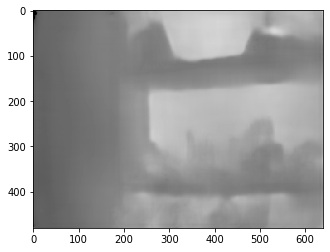

In [60]:
plt.imshow(pred_clipped, cmap="gray")

## Without Enhancement

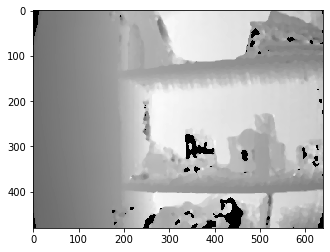

In [61]:
%matplotlib inline
depth_enhanced = np.copy(depth)
plt.imshow(depth, cmap="gray")

## With Enhancement

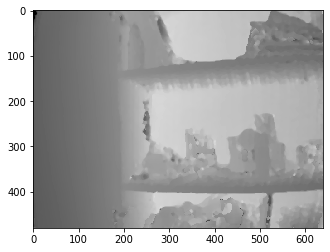

In [62]:
depth_enhanced[depth_enhanced==0] = pred_clipped[depth_enhanced==0]
plt.imshow(depth_enhanced, cmap="gray")

## Normalize

In [63]:
depth_enhanced = cv2.normalize(depth_enhanced, None, 0, 65535, cv2.NORM_MINMAX)
depth = cv2.normalize(depth, None, 0, 65535, cv2.NORM_MINMAX)

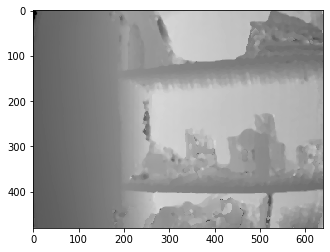

In [64]:
plt.imshow(depth_enhanced, cmap="gray")

## Combine

In [69]:
comb_1 = np.concatenate((infrared, depth, depth_enhanced), axis=1)

In [70]:
cv2.imwrite(os.path.join(path_images, 'enhanced_depth.png'), comb_1)

True